# Training eines LSTM-AE zur Anomalieerkennung

## 1. Vorbereitungen

#### Imports

In [1]:
%run -i ./scripts/PythonImports.py

Imports..


#### Set Configs

In [2]:
%run -i ./scripts/TrainPreperations.py

Set configs..
Read data..
Shape of normal data: (105216, 17)
Shape of anormal data: (35040, 18)


#### Scale Data and prepare for PyTorch

In [3]:
%run -i ./scripts/ScaleAndPrepare.py

Save column mapping..
Scale data..
Build PyTorch objects..


## 2. Training

In [4]:
from models.LSTMAutoEncoder import LSTMAutoEncoder
torch.manual_seed(42)

In [5]:
num_inputs = len(df_data.columns)
hidden_size = 12
num_layers = 1
latent_space_size = 8

model = LSTMAutoEncoder(input_size=num_inputs, hidden_size=hidden_size, latent_space_size=latent_space_size, num_layers=num_layers, isCuda=False)
critereon = mse_loss
#optimizer = Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

print(model)

LSTMAutoEncoder(
  (encoder): EncoderLSTM(
    (lstm_1): LSTM(17, 12, batch_first=True)
    (relu): ReLU()
    (lstm_2): LSTM(12, 8, batch_first=True)
    (tanh): Tanh()
  )
  (decoder): DecoderLSTM(
    (lstm_1): LSTM(8, 12, batch_first=True)
    (relu): ReLU()
    (lstm_2): LSTM(12, 17, batch_first=True)
    (tanh): Tanh()
  )
)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from RNNDataset import RNNDataset

In [8]:
dataSet = RNNDataset(data=scaled_train, window_size=8)
dataloader = torch.utils.data.DataLoader(dataSet, batch_size=32, shuffle=False)

In [9]:
losses = []
EPOCHS = 32

for epoch in range(EPOCHS):
    model.train()
    for batch_idx, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(data)
        loss = critereon(pred, target)
        losses.append(loss.cpu().data.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Display
        if batch_idx % 50 == 1:
            print('\n Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(trn_dataloader.dataset),
                100. * batch_idx / len(trn_dataloader), 
                loss.cpu().data.item()), 
                end='')


 Train Epoch: 1/32 [32/105216 (0%)]	Loss: nan
 Train Epoch: 1/32 [1632/105216 (6%)]	Loss: nan
 Train Epoch: 1/32 [3232/105216 (12%)]	Loss: nan

KeyboardInterrupt: 

### Save Model

In [10]:
model_fn = '{}_LSTM_AE_model.pt'.format(arrow.now().format('YYYYMMDD'))
print('Model Name: {}'.format(model_fn))
torch.save(model.state_dict(), os.path.join(model_bib_path, model_fn))

Model Name: 20200303_LSTM_AE_model.pt


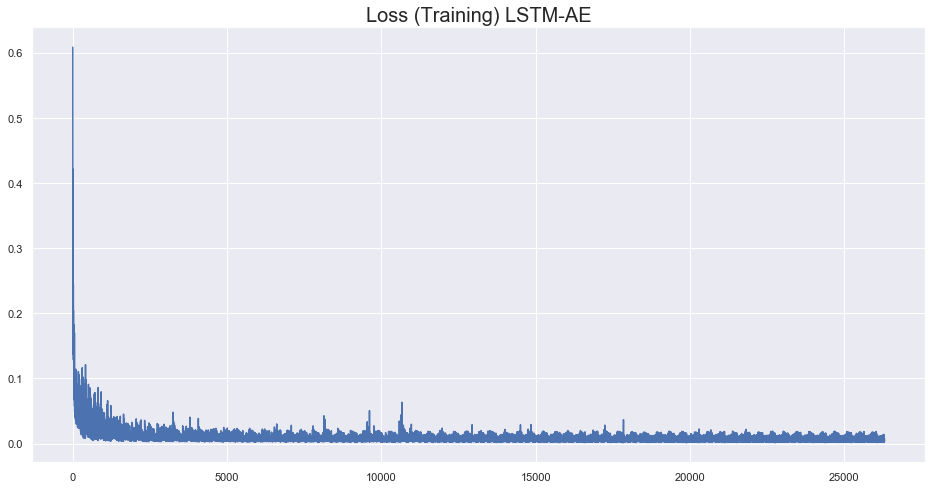

In [12]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.arange(len(losses)),losses)
plt.title('Loss (Training) LSTM-AE',fontsize=20)
loss_fn = '{}_LSTM_AE_model_loss.pdf'.format(arrow.now().format('YYYYMMDD'))
fn = os.path.join(fig_path, loss_fn)
fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0)

# Logistic Regression als Klassifikator für binäre Label

In [13]:
from sklearn.linear_model import LogisticRegression
from utils.evalUtils import calc_cm_metrics

torch.manual_seed(42)

In [14]:
from models.LSTMAutoEncoder import LSTMAutoEncoder
torch.manual_seed(42)

In [15]:
fn_now = os.path.join(model_path, 'model_bib' ,'20200303_LSTM_AE_model.pt')
num_inputs = len(df_data.columns)
hidden_size = 12
num_layers = 1
print('Num Inputs: {}'.format(num_inputs))

model = LSTMAutoEncoder(input_size=num_inputs, hidden_size=hidden_size, num_layers=num_layers, isCuda=False)

model.load_state_dict(torch.load(fn_now))
model.eval()

Num Inputs: 17


RuntimeError: Error(s) in loading state_dict for LSTMAutoEncoder:
	Unexpected key(s) in state_dict: "encoder.lstm.weight_ih_l1", "encoder.lstm.weight_hh_l1", "encoder.lstm.bias_ih_l1", "encoder.lstm.bias_hh_l1", "decoder.lstm.weight_ih_l1", "decoder.lstm.weight_hh_l1", "decoder.lstm.bias_ih_l1", "decoder.lstm.bias_hh_l1". 

In [7]:
data_fn_anormal = os.path.join(data_path, 'anomalous_data_y_2022_reduced.h5')
df_data_anormal = pd.read_hdf(data_fn_anormal, key='df')
print('Shape of anormal data: {}'.format(df_data_anormal.shape))

Shape of anormal data: (35040, 18)


In [8]:
s_labels = df_data_anormal['label']
df_data_anormal.drop('label', axis=1, inplace=True)

In [9]:
scaled_anormal = scaler_train.transform(df_data_anormal.to_numpy())

In [14]:
anormal_dataset = RNNDataset(data=scaled_anormal, window_size=8)
anormal_dataloader = torch.utils.data.DataLoader(anormal_dataset, batch_size=1, shuffle=False)

In [15]:
losses_anormal = []
for X, _ in anormal_dataloader:
    loss = model.calc_reconstruction_error(X)
    losses_anormal.append(loss.item())

    s_losses_anormal = pd.Series(losses_anormal)